# Can a Computer Identify Cuisine?
Browsing around for interesting datasets, I came across one awhile back that contained a collection of recipes from all over the world, tagged with their Region of Origin (not quite a nationality). Seeing this, I decided to try to see if I could predict this Region of Origin just from the ingredients list.

In [1]:
%matplotlib inline
import seaborn as sns
from recipes import classifiers, get_stats, training_data_vectorized, test_data_vectorized, use_clf
from math import log10, floor
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

sns.set()
matplotlib.rcParams['figure.figsize'] = (9.0, 6.5)

## What Makes This Unique?
At first this seems like a fairly basic NLP problem. Each recipe is essentially a sentence of terms. It seems to follow that I could classify these using the same techniques applied towards classifying natural language. And while I did make use of NLP techniques, most had limited, if any use, due to a couple of key differences:

### Each ingredient/word appears only once in any given recipe
Meaning that most fancy techniques of associating recipes based on how often a couple of terms appears in a document won't work.

### Word order is completely indifferent
Recipe ingredients are provided in an arbitrary order, so there is little point in using word-level ngrams, since there is no significance in the relative placements of words

### All sentences are short
Each recipe in the file is short, with the longest one still only having *(TODO: FIND LONGEST NUMBER)* total words. This is the main reason why I ended up not using tf-idf -- tf-idf is used to diminish the role that certain words play in longer documents that are likely to have many different words compared to smaller ones.

### Less filler words
Falling in with the last point, recipe listings are concise and don't generally have things like articles. I was lucky that my source didn't have any measurements attached, as that's a source of annoyance that I've had before in working with food ingredients. As mentioned before, tf-idf was not useful as there weren't many "universal" ingredients. PCA and similar techniques did not help improve my accuracy at all, so it's safe to conclude that there weren't any bogus ingredients throwing things off for me.

# Getting Started With The Data:

In [2]:
from sklearn.decomposition import PCA
X, cat = training_data_vectorized()
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())
print(pca.explained_variance_ratio_)

[ 0.06078811  0.02204006]


In the code above, we extract our training data and their labels from our dataset. The only change from our base training data, is that here X is already vectorized, so that PCA can directly work on it. PCA is applied to the data to bring it down to 2 vectors for plotting. Variance ratios are printed above.

In [3]:
def df_stats(df):
    size = df[df.columns[0]].size
    counts = df.groupby('Category').size().append(pd.Series(size, index=['Total']))
    percentages = counts / size * 100
    stats = pd.DataFrame({'Counts': counts, 'Percentages': percentages}).sort('Percentages', ascending=False)
    return stats

In [4]:
d = {'x': X_pca[:, 0], 'y': X_pca[:, 1], 'Category': cat}
df = pd.DataFrame(d)
#size = df.x.size
#counts = df.groupby('Category').size().append(pd.Series(size, index=['Total']))
#percentages = counts / size * 100
#stats = pd.DataFrame({'Counts': counts, 'Percentages': percentages}).sort('Percentages', ascending=False)
stats = df_stats(df)
print(stats)

                  Counts  Percentages
Category                             
Total              39548   100.000000
NorthAmerican      29106    73.596642
SouthernEuropean    2946     7.449176
LatinAmerican       1999     5.054617
WesternEuropean     1832     4.632346
EastAsian           1779     4.498331
MiddleEastern        453     1.145444
SouthAsian           424     1.072115
SoutheastAsian       307     0.776272
EasternEuropean      256     0.647315
African              253     0.639729
NorthernEuropean     193     0.488015


In [5]:
X_test, cat_test = test_data_vectorized()
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test.toarray())
print(pca.explained_variance_ratio_)

[ 0.06113418  0.02201807]


In [6]:
d_test = {'x': X_test_pca[:, 0], 'y': X_test_pca[:, 1], 'Category': cat_test}
df_test = pd.DataFrame(d_test)
#size_test = df_test.x.size
#counts_test = df_test.groupby('Category').size().append(pd.Series(size_test, index=['Total']))
#percentages_test = counts_test / size_test * 100
#stats_test = pd.DataFrame({'Counts': counts_test,
#                           'Percentages': percentages_test}).sort('Percentages', ascending=False)
stats_test = df_stats(df_test)
print(stats_test)

                  Counts  Percentages
Category                             
Total              16950   100.000000
NorthAmerican      12418    73.262537
SouthernEuropean    1234     7.280236
LatinAmerican        918     5.415929
WesternEuropean      827     4.879056
EastAsian            733     4.324484
SouthAsian           197     1.162242
MiddleEastern        192     1.132743
SoutheastAsian       150     0.884956
EasternEuropean      125     0.737463
African               99     0.584071
NorthernEuropean      57     0.336283


Next the data is put into a dataframe for exploratory examination. Counts of each class are made and its overall percentage compared to all categories is also calculated. As we can see, the data is heavily weighted towards NorthAmerican cuisine -- making up over 70% of all recipes, while no other category makes up even 10%. This heavy weighting will be an issue for correctly classifying the less common cuisines -- especially NorthernEuropean which has less than 200 recipes out of almost 40,000 total recipes.

Next let's plot each recipe, colored by their categories. As I am personally colorblind, I messed around with palettes to get one that I could better see. Colorblind was problamatic, as its limited number of colors meant that it cycled across categories, which caused a large loss of information due to the tightly packed nature of the points. I decided to use the 'hls' palette instead, as I found that it still gave me clear distinctions between points, with a diverse palette.

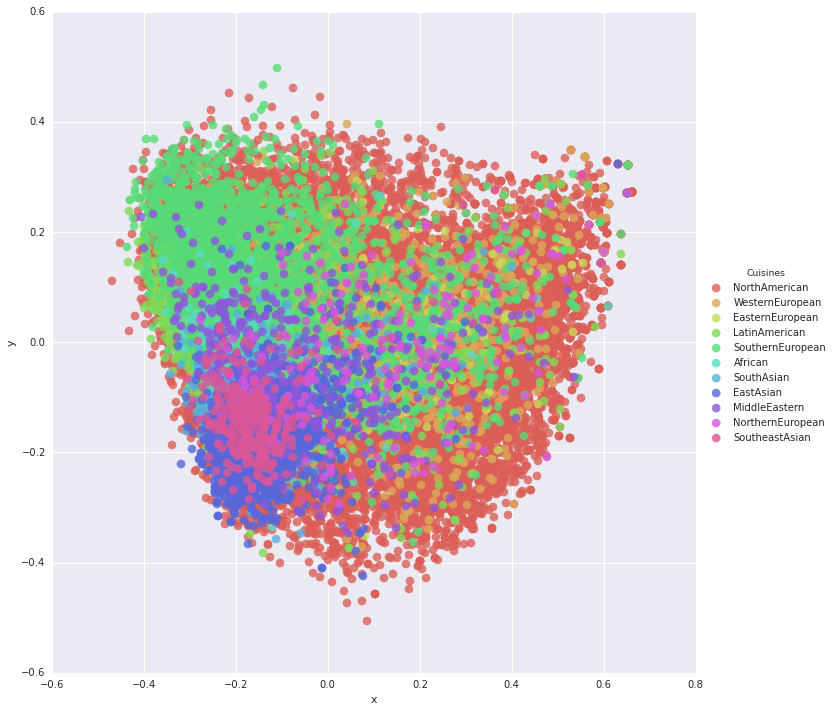

In [7]:
colorblind = False # Note that colorblind mode has limited number of colors, so it cycles

with sns.plotting_context(font_scale=2):
    if colorblind:
        sns.lmplot(x='x', y='y', hue='Category', data=df, fit_reg=False, palette='colorblind',
                   size=10, legend=False, scatter_kws={"s": 75}).add_legend(title='Categories')
    else:
        sns.lmplot(x='x', y='y', hue='Category', data=df, fit_reg=False, palette='hls',
                   size=10, legend=False, scatter_kws={"s": 75}).add_legend(title='Cuisines')

Aside from the oddly heart-shaped data, it is evident that while there exist divisions between the cuisines, many are tightly interwoven. Especially SoutheastAsian seems to be a narrower subset of EastAsian. This is likely due to the large cultural interchange and influences between these two regions. MiddleEastern Cuisine also seems to be tightly intertwined with SouthernEuropean -- an example of the culinary similarities amongst Mediterranean countries.

# Analysis:

## Pipeline
In order to transform the lists of string ingredients into numbers for classification algorithms, I created a pipeline of preprocessing algorithms that fed into my classifiers. This consisted of a CountVectorizer to convert each recipe into a sparse array of ingredients. This was fed into a Tf-Idf Transformer which would divide each of these vector terms by its overall frequency in the document. In the end, I ended up removing the idf part, since I found it added no real benefit. 

## Classifiers
Many classifiers were tested on the data, but the three best that I decided to keep were two **Logistic Regression** classifiers and one **Naive Bayesian** classifier. The difference between the two Logistic Regression classifiers is their weightings. *Logistic1* weighes each sample inverse to their frequency within the data set. This allows it to more accurately rate less common cuisines better, without too heavily biasing towards NorthAmerican cuisine. *Logistic2* simply weighes each class the same way.

## Results
We begin by creating a number of useful helper functions. These allow us to transform a classifier's confusion matrix into a confusion-percentage matrix, where each column indicates the percentage of prediction for each true class. This is useful for displaying a heatmap, as it normalizes all squares. This'll de-emphasize the NorthAmerican data.

We also quickly define a function for getting the mean accuracy of each classifier. This is simply the percentage that each classifier manages to correctly predict from the test data.

In [8]:
def stats_count():
    s = stats_test.sort()['Counts'].drop(['Total'])
    return s.append(pd.Series(stats_test['Counts']['Total'], index=['Total']))
def get_confusion(clf): return get_stats(clf)[-1]
def percentage(s):
    return s / stats_count().values * 100
def confusion_percentage_matrix(confusion):
    return confusion.apply(percentage).drop('All', axis=1)
def accuracy(clf): return get_stats(clf)[1] * 100

Let's next plot the accuracy of each of the three classifiers used:

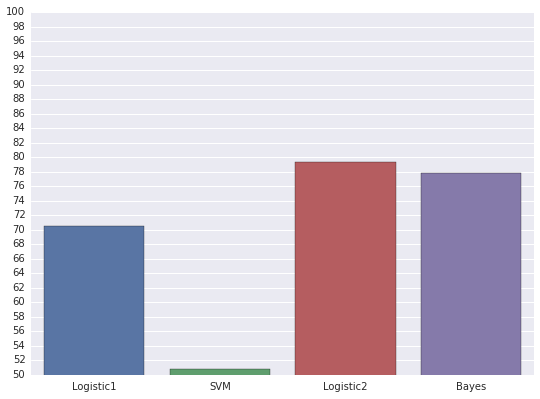

In [9]:
accuracies = [accuracy(val) for val in classifiers.values()]
plt.ylim(50,100)
plt.yticks(np.arange(50, 101, 2))
sns.barplot(list(classifiers.keys()), accuracies)

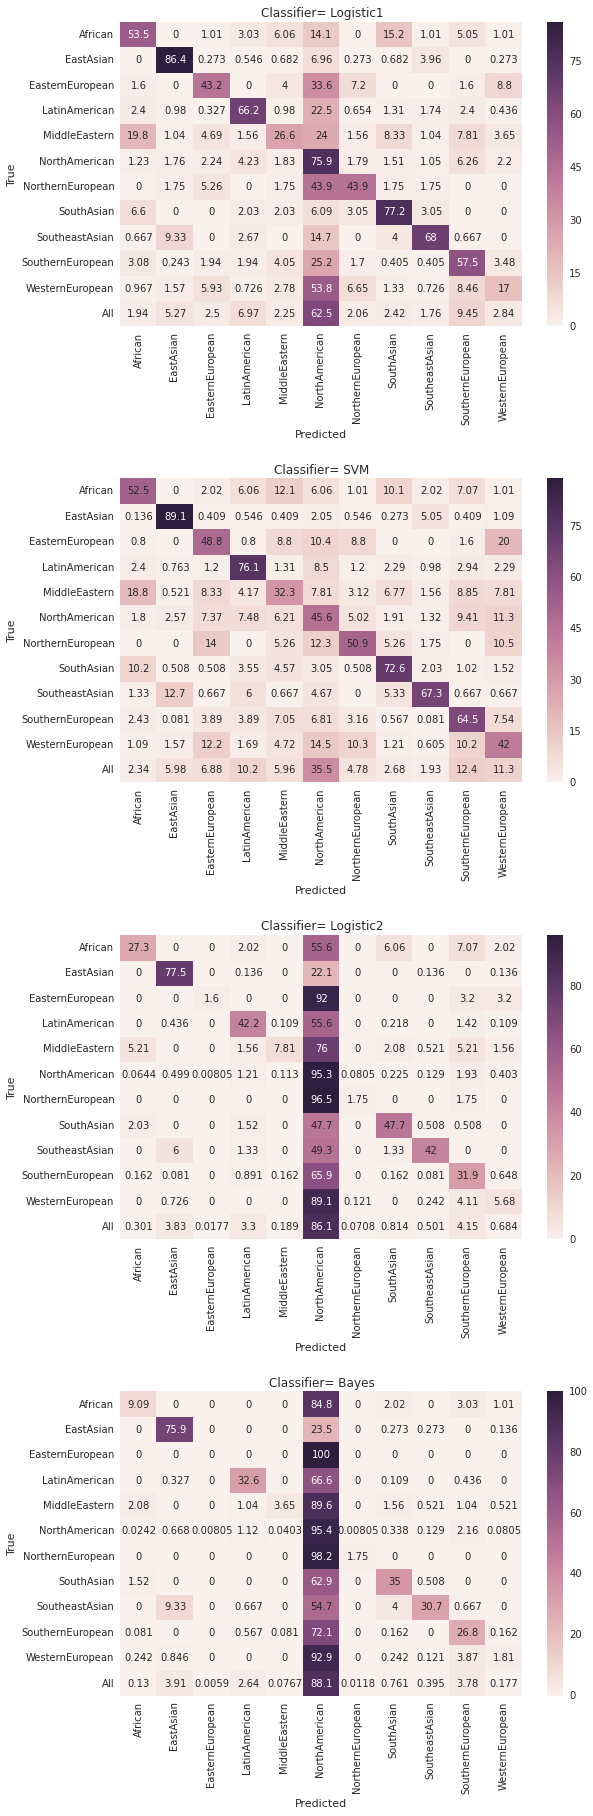

In [10]:
confusions = {key: confusion_percentage_matrix(get_confusion(value))
              for key,value in classifiers.items()}

f, axs = plt.subplots(len(confusions), figsize=(9,30))
plt.subplots_adjust(hspace= 0.5)

for key, ax in zip(confusions.keys(), axs):
    sns.heatmap(confusions[key], annot=True, fmt='.3g', ax=ax)
    ax.set_title('Classifier= %s' % key)

As you can see, while *Logistic1* has poor overall accuracy compared to the two other classifiers, it does a significantly better job at classifying non-NorthAmerican recipes correctly. This is especially true for the least common cuisines such as African, NorthernEuropean, and EasternEuropean.

Let's investigate this difference some more:

In [11]:
unweighted_accuracy = pd.DataFrame({k: conf.values.diagonal() for k, conf in confusions.items()},
                                   index=confusions['Bayes'].index.values[:-1])
random_guess = 100 / 11
unweighted_accuracy.loc[:, 'Random'] = random_guess
unweighted_accuracy.loc['Mean'] = unweighted_accuracy.mean()
unweighted_accuracy.loc['Median'] = unweighted_accuracy.median()
unweighted_accuracy

,Bayes,Logistic1,Logistic2,SVM,Random
African,9.090909,53.535354,27.272727,52.525253,9.090909
EastAsian,75.852660,86.357435,77.489768,89.085948,9.090909
EasternEuropean,0.000000,43.200000,1.600000,48.800000,9.090909
LatinAmerican,32.570806,66.230937,42.156863,76.143791,9.090909
MiddleEastern,3.645833,26.562500,7.812500,32.291667,9.090909
NorthAmerican,95.425995,75.905943,95.337413,45.619262,9.090909
NorthernEuropean,1.754386,43.859649,1.754386,50.877193,9.090909
SouthAsian,35.025381,77.157360,47.715736,72.588832,9.090909
SoutheastAsian,30.666667,68.000000,42.000000,67.333333,9.090909
SouthernEuropean,26.823339,57.536467,31.928687,64.505673,9.090909


Above I've calculated the accuracy each classifier gets for each different cuisine, along with the accuracy a 4th "classifier" would approximately get if it guessed uniformally for each example. Finally, I also included the unweighted mean and median results for each classifier across all cuisines. Let's plot these out:

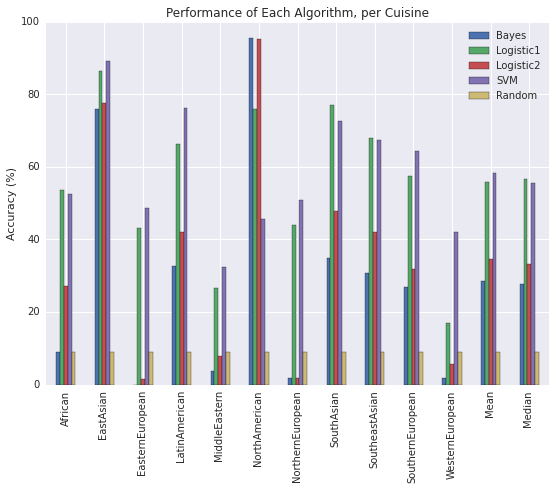

In [12]:
unweighted_accuracy.plot(kind='bar', title='Performance of Each Algorithm, per Cuisine').set_ylabel('Accuracy (%)')

Above I have plotted out the accuracies of each classifier from the prior table. As we can see,the *Logistic1* classifier appears to do better on all tasks besides classifying NorthAmerican cuisine. Seeing as this classifier was trained by weighting examples to more fairly consider each category, it is evident that the disproportionate quantity of NorthAmerican cuisine had a huge negative impact on the performance of the others for generalizing this accuracy. Let's now look at each of these cuisines independently, to get a better idea on this difference:

In [13]:
def arrange_data(df, cols=None):
    stacked = df.stack()
    df_stacked = pd.DataFrame(stacked).reset_index()
    if cols:
        df_stacked.columns = cols
    return df_stacked

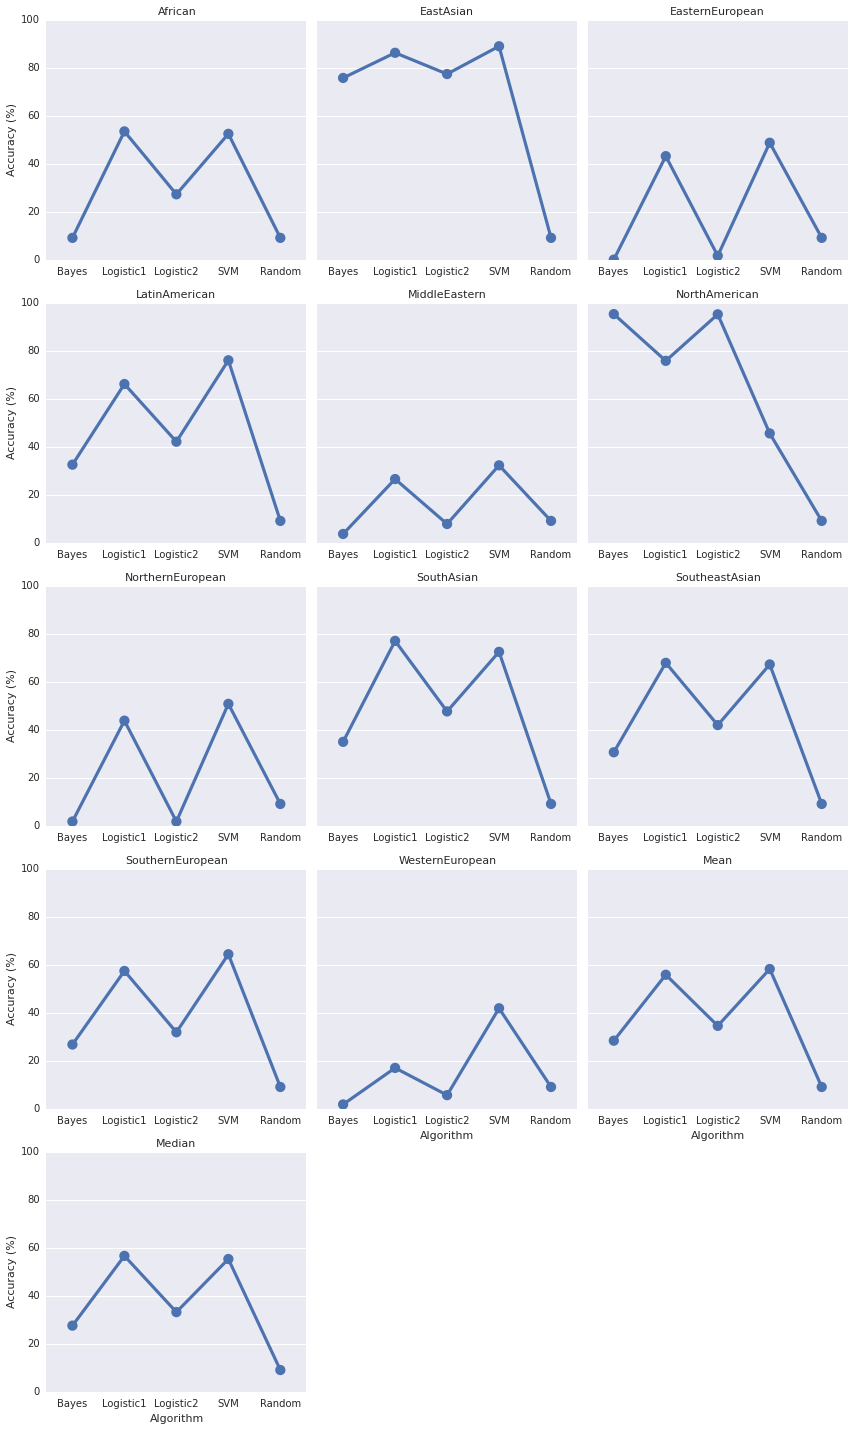

In [14]:
sns.factorplot(x='Algorithm', y='Accuracy', col='Cuisine', col_wrap=3, sharex=False, #kind='bar',
               data=arrange_data(unweighted_accuracy, cols=['Cuisine', 'Algorithm', 'Accuracy']),
               facet_kws = {'ylim': (0, 100)}).set_axis_labels('Algorithm', 'Accuracy (%)')\
                                              .set_titles('{col_name}')

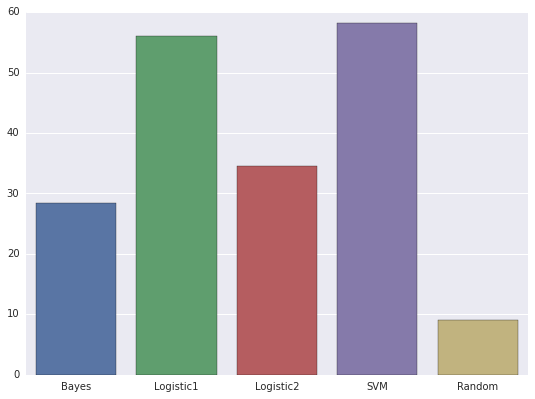

In [15]:
#sns.clustermap(data=unweighted_accuracy)
#unweighted_accuracy.pivot(index)
sns.barplot(data=unweighted_accuracy, ci=None)

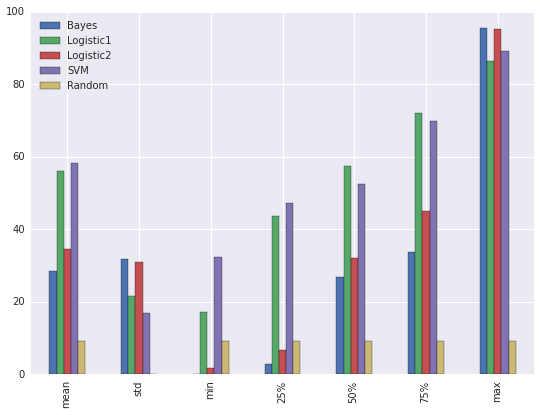

In [16]:
# Not sure where to put this, yet. May want to re-order groupings here...
# Somewhere mention how this shows that Logistic1 has a lower variance/is more consistent.
unweighted_accuracy.iloc[:-2].describe().iloc[1:].plot(kind='bar')

In [17]:
unweighted_accuracy.iloc[:-2].describe().iloc[1:]

,Bayes,Logistic1,Logistic2,SVM,Random
mean,28.424524,55.945020,34.613752,58.339076,9.090909
std,31.657752,21.719711,30.975576,16.951115,0.000000
min,0.000000,17.049577,1.600000,32.291667,9.090909
25%,2.729809,43.529825,6.747846,47.209631,9.090909
50%,26.823339,57.536467,31.928687,52.525253,9.090909
75%,33.798093,71.952971,44.936299,69.961083,9.090909
max,95.425995,86.357435,95.337413,89.085948,9.090909


In [18]:
# Here I should create a dataframe for the calculated accuracies vs the unweighted mean accuracies, by algorithm
# Then I'll plot a bar graph comparing these values side-by-side to better emphasize the huge difference.


# TODO:

Further research, look into techniques for better equalizing the frequency of input data, see if it can train all classifiers to be better at figuring out the differences between classes. Especially Bayes is very biased with these huge NA numbers.

See if I can make blending work.

In [19]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from unbalanced_dataset import UnderSampler

ratio = np.count_nonzero(cat[cat=='NorthAmerican']) / np.count_nonzero(cat[cat!='NorthAmerican'])
encoder = LabelEncoder()
y = encoder.fit_transform(cat)
#smote = SMOTE(ratio=ratio, verbose=True, kind='regular')
#X_balanced, y_balanced = smote.fit_transform(X.toarray(), y)
undersampler = UnderSampler(verbose=True)
X_balanced, y_balanced = undersampler.fit_transform(X.toarray(), y)
cat_balanced = encoder.inverse_transform(y_balanced.astype('int'))
X_balanced.shape
#cat_balanced

Determining classes statistics... 11 classes detected: {0: 253, 1: 1779, 2: 256, 3: 1999, 4: 453, 5: 29106, 6: 193, 7: 424, 8: 307, 9: 2946, 10: 1832}
Under-sampling performed: Counter({0: 193, 1: 193, 2: 193, 3: 193, 4: 193, 5: 193, 6: 193, 7: 193, 8: 193, 9: 193, 10: 193})


(2123, 373)

In [20]:
pca = PCA(n_components=2)
X_balanced_pca = pca.fit_transform(X_balanced)


In [21]:

df_balanced = pd.DataFrame({'x': X_balanced_pca[:, 0], 'y': X_balanced_pca[:, 1], 'Category': cat_balanced})
size = df_balanced.x.size
stats_balanced = df_stats(df_balanced)
print(stats_balanced)

                  Counts  Percentages
Category                             
Total               2123   100.000000
African              193     9.090909
EastAsian            193     9.090909
EasternEuropean      193     9.090909
LatinAmerican        193     9.090909
MiddleEastern        193     9.090909
NorthAmerican        193     9.090909
NorthernEuropean     193     9.090909
SouthAsian           193     9.090909
SoutheastAsian       193     9.090909
SouthernEuropean     193     9.090909
WesternEuropean      193     9.090909


In [22]:
# Must implement this balanced stuff in recipes.py cannot use vectorized versions here.
# Should create a new pipeline for this stuff.
#clf = use_clf(MultinomialNB(), 'Bayes-Balanced', x=X_balanced, y=cat_balanced)